In [ ]:
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

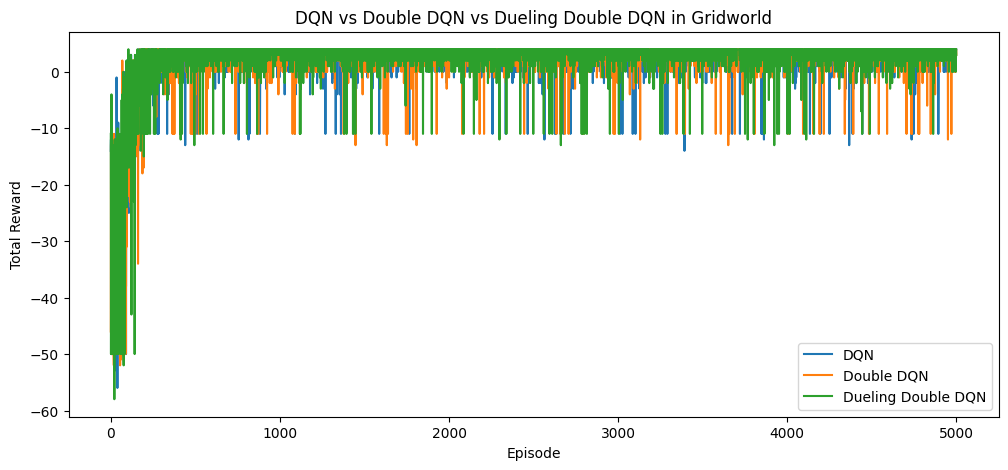

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

from Gridworld import Gridworld

# === 環境參數 ===
ACTIONS = ['u', 'd', 'l', 'r']
ACTION_SIZE = len(ACTIONS)
STATE_SIZE = 4*4*4   # Gridworld 的 render_np 輸出 shape

# --- 共用 Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(tuple(args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.stack(state), np.array(action), np.array(reward), np.stack(next_state), np.array(done)
    def __len__(self):
        return len(self.buffer)

def state_to_flat(state):
    return state.flatten().astype(np.float32)

# --- 三種網路架構 ---
class DQNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(STATE_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, ACTION_SIZE)
        )
    def forward(self, x):
        return self.fc(x)

class DuelingDQNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(STATE_SIZE, 128),
            nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.advantage = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, ACTION_SIZE)
        )
    def forward(self, x):
        x = self.feature(x)
        val = self.value(x)
        adv = self.advantage(x)
        q = val + (adv - adv.mean(dim=1, keepdim=True))
        return q

# --- Agent 實作 ---
class Agent:
    def __init__(self, net_class, gamma=0.99, lr=1e-3, buffer_size=5000, batch_size=64, double=False, dueling=False):
        self.model = net_class()
        self.target_model = net_class()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_size)
        self.loss_fn = nn.MSELoss()
        self.double = double

    def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(ACTION_SIZE)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q = self.model(state)
        return q.argmax().item()

    def push(self, s, a, r, ns, done):
        self.buffer.push(s, a, r, ns, done)

    def update(self):
        if len(self.buffer) < self.batch_size:
            return 0
        s, a, r, ns, done = self.buffer.sample(self.batch_size)
        s = torch.tensor(s, dtype=torch.float32)
        a = torch.tensor(a, dtype=torch.long)
        r = torch.tensor(r, dtype=torch.float32)
        ns = torch.tensor(ns, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)

        qvals = self.model(s)
        qval = qvals.gather(1, a.view(-1,1)).squeeze()

        with torch.no_grad():
            if self.double:
                next_action = self.model(ns).argmax(1, keepdim=True)
                next_q = self.target_model(ns).gather(1, next_action).squeeze()
            else:
                next_q = self.target_model(ns).max(1)[0]
            target = r + self.gamma * next_q * (1 - done)
        loss = self.loss_fn(qval, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

# --- 訓練函數 ---
def train_agent(agent, episodes=300, update_target_every=20, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
    rewards = []
    losses = []
    epsilon = epsilon_start
    for ep in range(episodes):
        env = Gridworld(size=4)
        state = state_to_flat(env.board.render_np())
        total_reward = 0
        for step in range(50):  # 最多50步
            action = agent.act(state, epsilon)
            env.makeMove(ACTIONS[action])
            reward = env.reward()
            next_state = state_to_flat(env.board.render_np())
            done = (reward == 10 or reward == -10)
            agent.push(state, action, reward, next_state, done)
            loss = agent.update()
            losses.append(loss)
            state = next_state
            total_reward += reward
            if done:
                break
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        if ep % update_target_every == 0:
            agent.update_target()
        rewards.append(total_reward)
    return rewards, losses

# === 三種模型一起訓練與比較 ===
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

dqn_agent = Agent(DQNNet, double=False)
double_dqn_agent = Agent(DQNNet, double=True)
dueling_dqn_agent = Agent(DuelingDQNNet, double=True)  # Dueling 也用 Double 技巧

EPISODES = 5000

rewards_dqn, losses_dqn = train_agent(dqn_agent, episodes=EPISODES)
rewards_double, losses_double = train_agent(double_dqn_agent, episodes=EPISODES)
rewards_dueling, losses_dueling = train_agent(dueling_dqn_agent, episodes=EPISODES)

# --- 畫圖 ---
plt.figure(figsize=(12,5))
plt.plot(rewards_dqn, label='DQN')
plt.plot(rewards_double, label='Double DQN')
plt.plot(rewards_dueling, label='Dueling Double DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.title('DQN vs Double DQN vs Dueling Double DQN in Gridworld')
plt.show()